August: Animations of the vertical velocity (W) profiles at different depths using pcolormesh and contour lines.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec

from salishsea_tools.nc_tools import scDataset

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from matplotlib import animation

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

# ------------------------------------------------------------------------------------------------
def get_vars(dirname, depth_ind):
    fname = "1_MCKNZ_1h_20170101_20170120_*"
    y,x = slice(1,-1,None), slice(1,-1,None)
    
    filesT = get_files(dirname, fname, 'grid_T')
    filesU = get_files(dirname, fname, 'grid_U') 
    filesW = get_files(dirname, fname, 'grid_W')
            
    with scDataset(filesT) as dsT, scDataset(filesU) as dsU, scDataset(filesW) as dsW:
        deptht = dsT.variables['deptht'][depth_ind]
        sozotaux = dsU.variables['sozotaux'][:,0,0]        
        vovecrtz0 = dsW.variables['vovecrtz'][:,depth_ind,y,x]
        
    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        tmask0 = dsM.variables['tmask'][0,depth_ind,y,x]
        
    tmask = np.tile(tmask0, (len(sozotaux),1, 1))  
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    vovecrtz_cm = vovecrtz[:] * 100
    
    return vovecrtz_cm, sozotaux, deptht

In [3]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'

vovecrtzA, sozotaux, depthtA = get_vars(dirname, 7)
vovecrtzB, sozotaux, depthtB = get_vars(dirname, 9)
vovecrtzC, sozotaux, depthtC = get_vars(dirname, 11)

print(depthtA, depthtB, depthtC)

65.625 83.125 100.625


In [60]:
def set_plots():
    fig = plt.figure(figsize=(20, 12))
    ax1 = plt.subplot2grid((6, 12), (0, 0), colspan=4, rowspan=4)
    ax2 = plt.subplot2grid((6, 12), (0, 4), colspan=4, rowspan=4, sharey=ax1)
    ax3 = plt.subplot2grid((6, 12), (0, 8), colspan=4, rowspan=4, sharey=ax1)
    axa = plt.subplot2grid((6, 12), (4, 0), colspan=12)
    
    for pos in ['top', 'bottom', 'right', 'left']:
        ax1.spines[pos].set_edgecolor('gray')
        ax2.spines[pos].set_edgecolor('gray')
        ax3.spines[pos].set_edgecolor('gray')
        axa.spines[pos].set_edgecolor('gray')
        axa.spines[pos].set_visible(False)
    
    axa.set_xlabel('Time [hrs]', fontsize=13)
    axa.set_title('Wind Stress [Nm$^{-2}$]', fontsize=13)
    axa.grid(color='gray', linestyle='-')
    axa.xaxis.set_ticks_position('none') 
    axa.yaxis.set_ticks_position('none') 
    plt.tight_layout(h_pad=0.5, rect=[0, 0, 1, 0.96]) 
    return fig, ax1, ax2, ax3, axa

# ------------------------------------------------------------------------------------
    
def set_plots_clear(ax, depm):
    ax.set_xlabel('X Indices (Child)', fontsize=13)
    ax.set_ylabel('Y Indices (Child)', fontsize=13, labelpad=10)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    ax.set_title('W Velocity [cm s$^{-1}$]    (dep=' + str(int(depm)) + ' m)', fontsize=20)
    return ax

# ------------------------------------------------------------------------------------

def get_vlimits(vovecrtzA, vovecrtzB, vovecrtzC):
    vel_max = max(vovecrtzA.max(), vovecrtzB.max(), vovecrtzC.max(), key=abs)
    vel_min = max(vovecrtzA.min(), vovecrtzB.min(), vovecrtzC.min(), key=abs)
    vm0 = max([abs(vel_max), abs(vel_min)])
    vm = 0.4 * vm0
    levels = np.linspace(-1*vm, vm, 6).tolist()
    return vm, levels

# ------------------------------------------------------------------------------------

def set_xy(ax, vel_array):
    xs = np.arange(vel_array.shape[-1])
    ys = np.arange(vel_array.shape[-2])
    ax.set_xlim([0, xs[-1]]); ax.set_ylim([0, ys[-1]])
    return ax, xs, ys

# ------------------------------------------------------------------------------------

def init():
    for vel_array, ax in zip ([vovecrtzA, vovecrtzB, vovecrtzC], [ax1, ax2, ax3]):
        vel = vel_array[0,...]
        ax, xs, ys = set_xy(ax, vel_array)
        cs = ax.contour(xs, ys, vel, levels = levels, colors='k')
    return cs,

def animate(time_ind):
    ax1.cla(); ax2.cla(); ax3.cla()
    for ax,vel_array,depm in zip ([ax1, ax2, ax3],[vovecrtzA, vovecrtzB, vovecrtzC],[depthtA, depthtB, depthtC]):
        ax = set_plots_clear(ax, depm)
        vel = vel_array[time_ind,...]
        ax, xs, ys = set_xy(ax, vel_array)
        
        cs = ax.contour(xs, ys, vel, levels = levels, colors='k')
        ax.clabel(cs, inline=1, fontsize=10)
        
        cmap = plt.get_cmap(cm.RdBu_r)
        cmap.set_bad('wheat')
        P = ax.pcolormesh(xs, ys, vel, vmin = -1*vm, vmax = vm, cmap = cmap)
        
        if time_ind == 0:
            cbar = plt.colorbar(P, ax=ax, pad=0.1, orientation='horizontal', extend='both')
            cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation=45)
        else:
            pass
        
    axa.plot(sozotaux[:time_ind], c='#384e72', linewidth=2.5)
    axa.set_xlim([0, sozotaux.shape[0]])
    axa.set_ylim(sozotaux.min(), sozotaux.max())
    return cs,

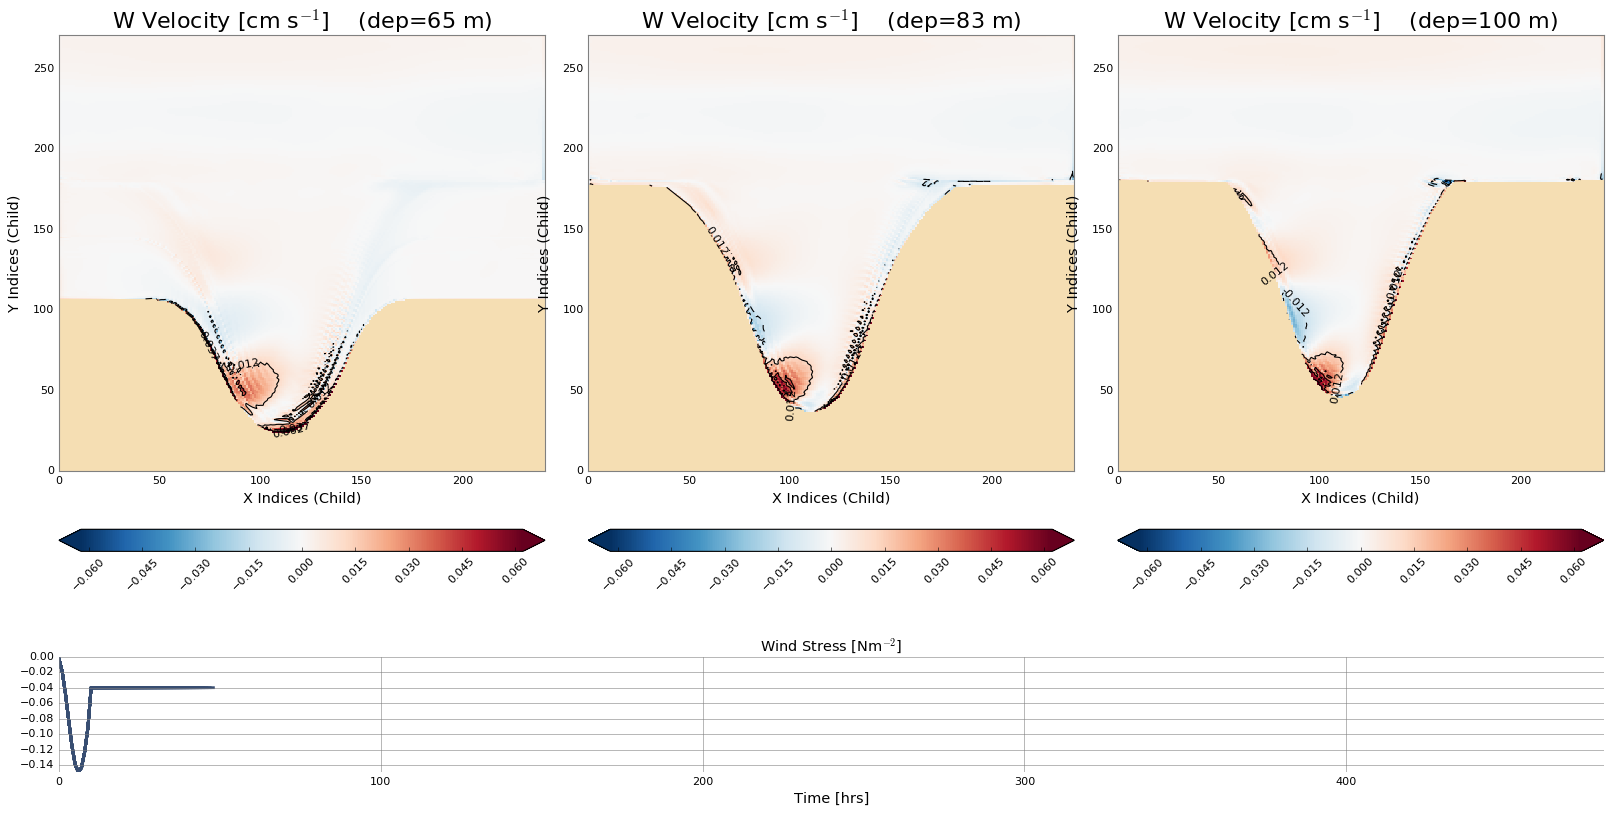

In [61]:
fig, ax1, ax2, ax3, axa = set_plots()
vm, levels = get_vlimits(vovecrtzA, vovecrtzB, vovecrtzC)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=3, bitrate=1000000, codec="libx264")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=50)
anim.save('uvw.mp4', writer=writer)